In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import scipy.cluster as cluster
import scipy
from tqdm import trange, tqdm

import boost_histogram as bh
from numba import jit, njit

In [2]:
def count_frames(video):
    total = 0
    # loop over the frames of the video
    while True:
        # grab the current frame
        (grabbed, frame) = video.read()

        # check to see if we have reached the end of the
        # video
        if not grabbed:
            break
        # increment the total number of frames read
        total += 1
    # return the total number of frames in the video file
    video.set(1, 0)
    return total

def half_size(frame):
    return cv2.resize(frame, (frame.shape[1]//2, frame.shape[0]//2))

def get_frames(video):
    total = count_frames(video)
    video.set(1, 0)
    frames = []
    for i in trange(200):
        (grabbed, frame) = video.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)/256
        frame = half_size(frame)
        frames.append(frame)
        
    return frames
        
    

In [3]:
%%time
# cap = cv2.VideoCapture("/Users/tylern/Downloads/Do You Love Me-fn3KWM1kuAw.mkv")
cap = cv2.VideoCapture("/Users/tylern/Desktop/Wire-kGj_HkKhhSE.mkv")
#cap = cv2.VideoCapture("/Users/tylern/Desktop/Star.Wars.EPISODE.IV-A.NEW.HOPE.BRRiP.XViD.AC3-LEGi0N.avi")
# cap.set(1, 0)
# total_frames = count_frames(cap)
# total_frames = int(total_frames*0.001)

CPU times: user 19.8 ms, sys: 4.4 ms, total: 24.2 ms
Wall time: 22.4 ms


In [4]:
%%time
frames = get_frames(cap)
#print(frames)

100%|██████████| 200/200 [00:04<00:00, 40.53it/s]

CPU times: user 31.9 s, sys: 13.4 s, total: 45.3 s
Wall time: 12.5 s


In [ ]:
#cap = cv2.VideoCapture("/Users/tylern/Desktop/Star.Wars.EPISODE.IV-A.NEW.HOPE.BRRiP.XViD.AC3-LEGi0N.avi")

NUM_COLORS = 2
colors = []

for i in trange(total_frames):
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Our operations on the frame come here
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)/256
    #image = image[:512,:512,:]
    ar = np.asarray(image)
    ar = ar.reshape(np.product(ar.shape[:2]), ar.shape[2]).astype(float)
    
    codes, dist = cluster.vq.kmeans(ar, NUM_COLORS)
    vecs, dist = cluster.vq.vq(ar, codes)         # assign codes
    counts, bins = np.histogram(vecs, len(codes))    # count occurrences

    peak = codes[np.argmax(counts)]
    color = [[(peak[0], peak[1], peak[2])]]
    colors.append(peak)

    # plt.imshow(color)
    # plt.show()

    # plt.imshow(image)
    # plt.show()

# When everything done, release the capture
cap.release()

In [ ]:
for i, c in enumerate(colors):
    plt.axvline(i, c=c, lw=16)

plt.show()

In [ ]:
plt.imshow(frames[1000])

np.median(frames[1000])

In [ ]:
def plotHist(img):
    # img = np.round(img, 1)
    plt.imshow(np.round(img, 1))
    plt.show()
    
    colors = {
        0 : 'r',
        1 : 'g',
        2 : 'b',
    }
    for k, v in colors.items():
        y, x = bh.numpy.histogram(img[:, :, k].flatten(), bins=128, range=[0,1], density=True)
        plt.step(x[:-1], y, color=v)
        
        print(x[np.argmax(y)])
        
    plt.show()
    
    return 0 # dominant_color

plotHist(frames[0])

In [34]:
def GetMax(img):
    # values = defaultdict(lambda: 0)
    img = np.round(img, 3)
    img = img.reshape(img.shape[0]*img.shape[1], img.shape[2])
    
    c = Counter(map(tuple, img))
    maximum = c.most_common()[0][0]
    rgb = [x for x in maximum]
    rgb.append(1)
    
    return np.array(rgb).T

@njit
def GetMax2(img):
    values = {}
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            try:
                values[tuple((img[i, j, 0], img[i, j, 1], img[i, j, 2]))] += 1
            except:
                values[tuple((img[i, j, 0], img[i, j, 1], img[i, j, 2]))] = 1
                

    maximum = max(values.values())
    rgb = []
    for k, v in values.items():
        if v == maximum:
            rgb.append(k[0])
            rgb.append(k[1])
            rgb.append(k[2])
            rgb.append(1)

    return np.array(rgb).T

In [35]:
colors = np.zeros((192,len(frames), 4))
for i, f in tqdm(enumerate(frames[0:200])):
    colors[:,i] = GetMax2(f)

200it [00:19, 10.44it/s]


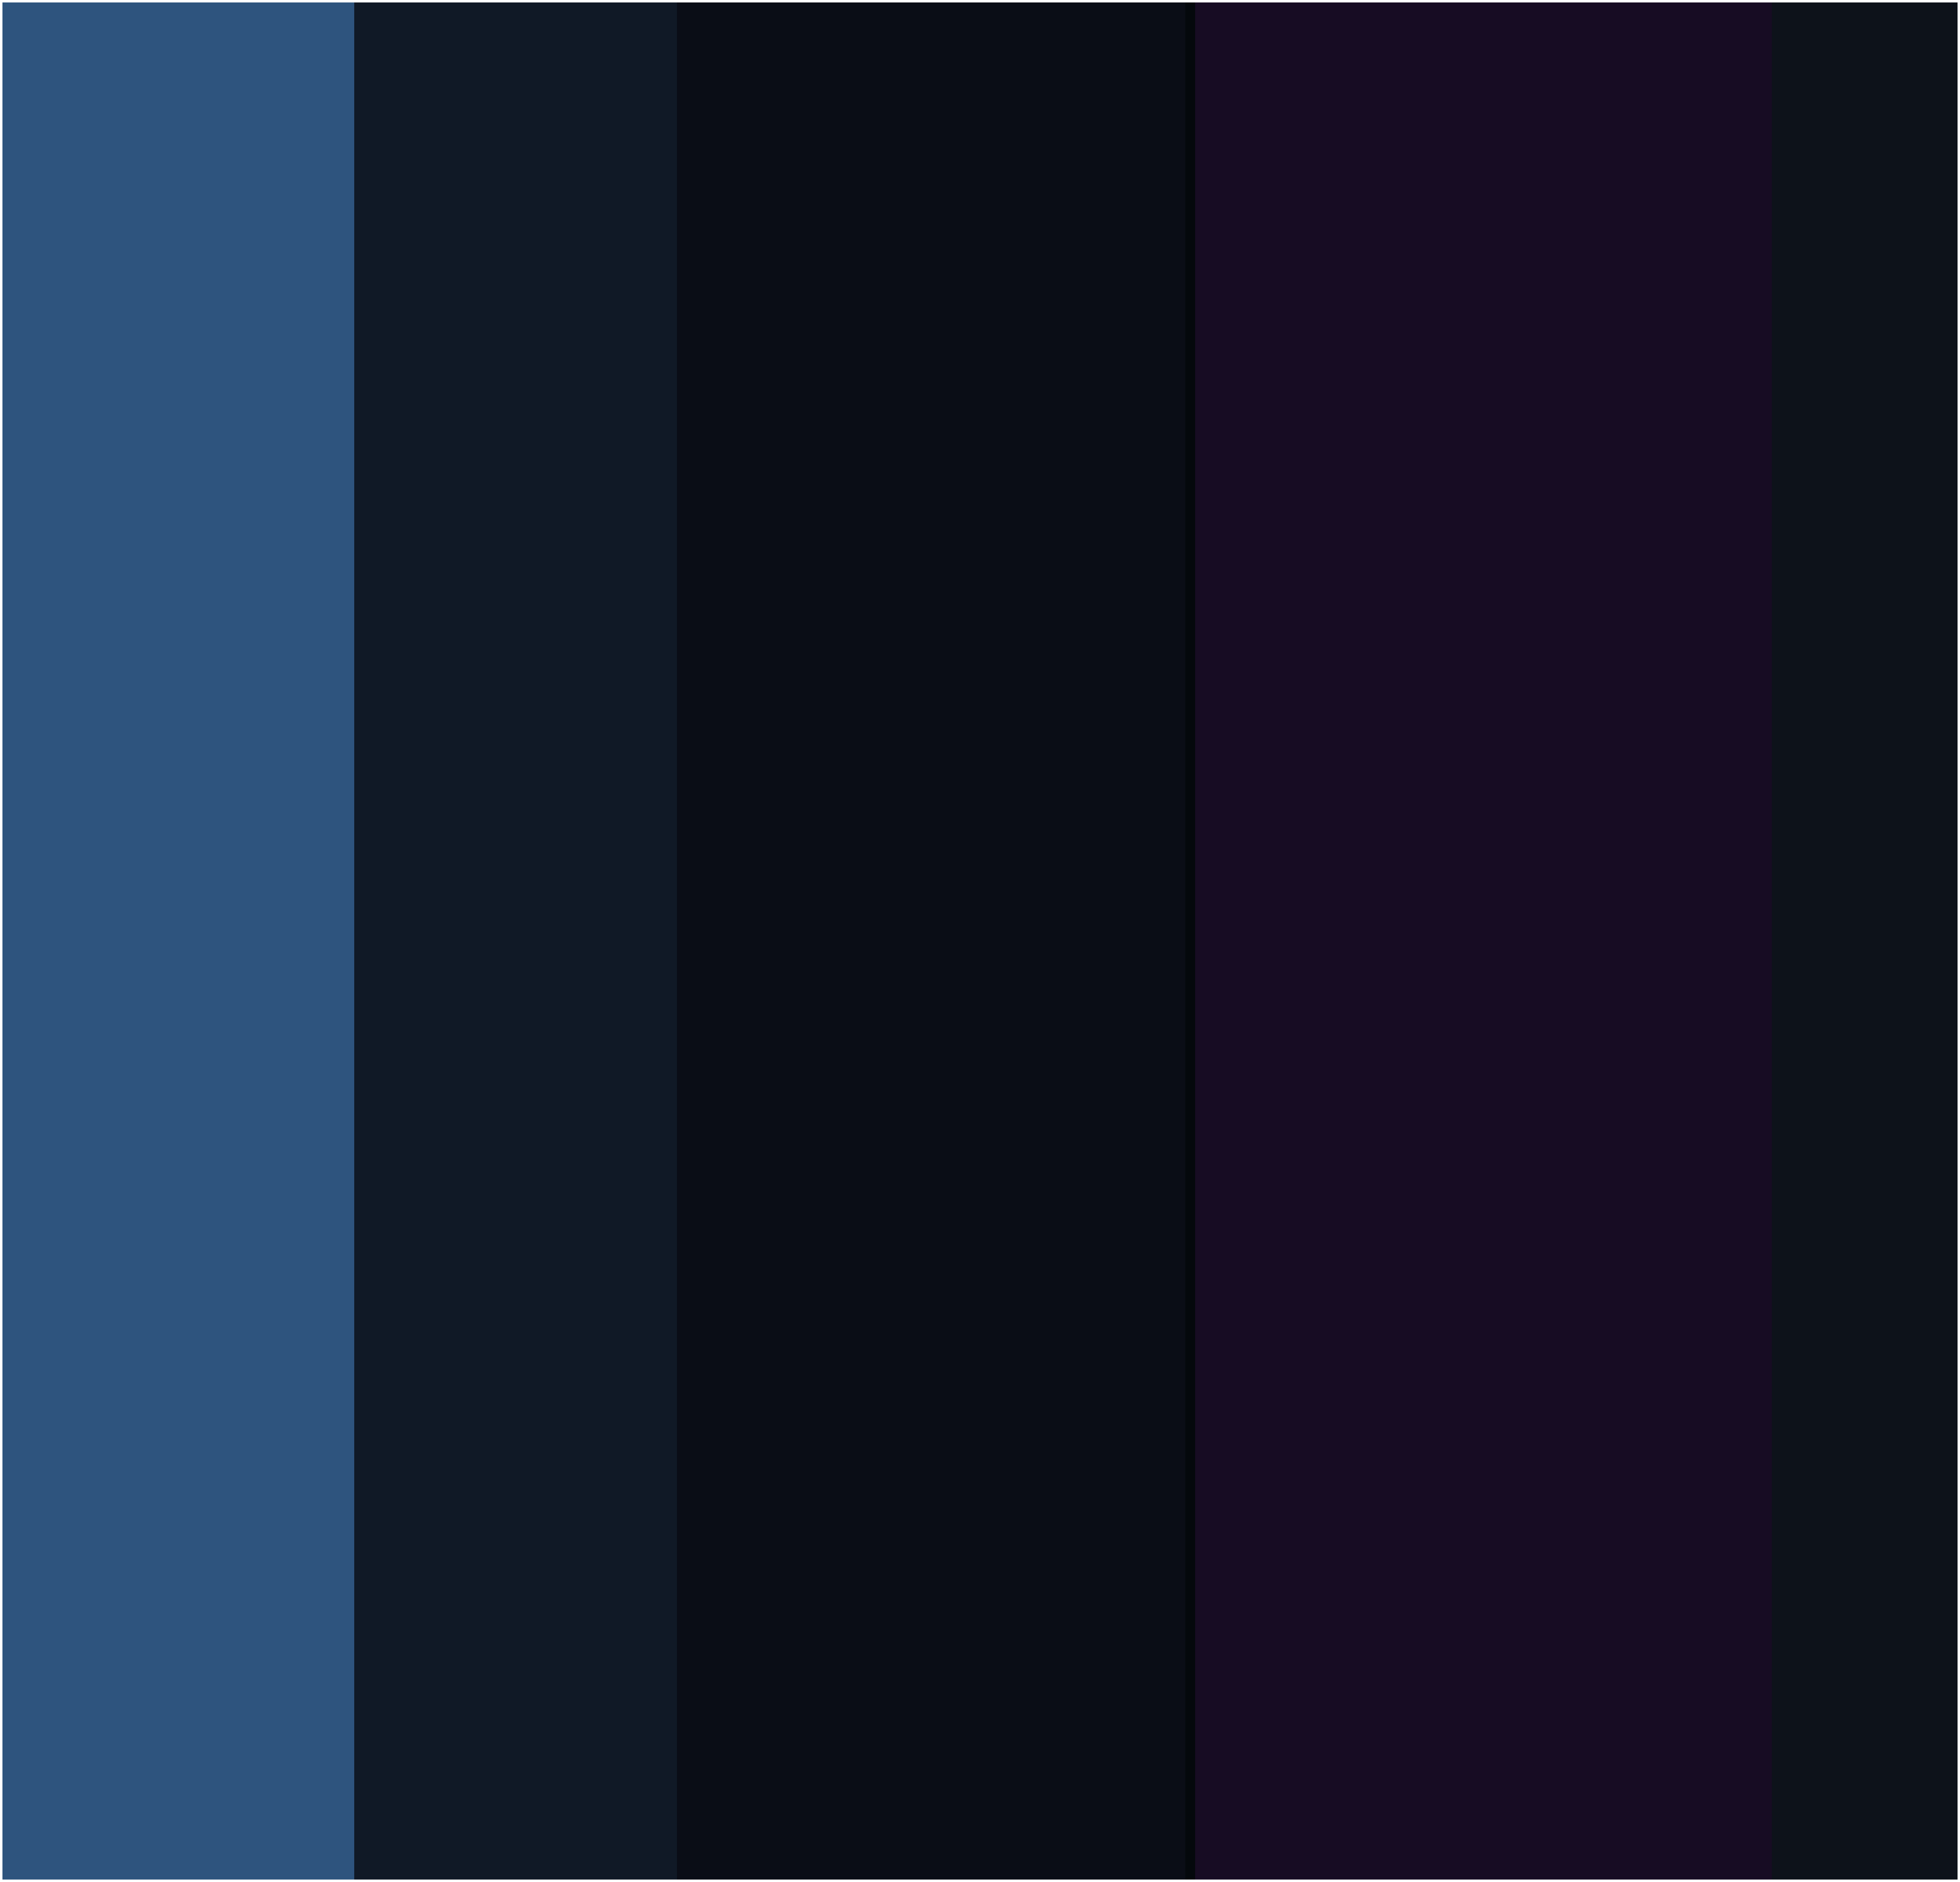

In [36]:
fig, ax = plt.subplots(figsize=[100,100])
plt.imshow(np.array(colors))
plt.axis("off")
plt.show()